In [ ]:
import sys, os
import numpy as np
import glob
import pickle
import cv2
import matplotlib.pyplot as plt
import json
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn
%matplotlib inline

In [71]:
def get_gps(json_path, video_filename):
    with open(json_path) as data_file:    
        data = json.load(data_file)
    
    seg = [x for x in data['segments'] if x['filename']==video_filename]
    assert(len(seg)==1)
    seg = seg[0]
    locs = seg['locations']
    loc2nparray = lambda locs, key: np.array([x[key] for x in locs]).ravel()
    
    res = {}
    bad_video_c = 0
    bad_video_t = 0
    bad_video_same = 0
    for ifile, f in enumerate(locs):
        if int(f['course']) == -1 or int(f['speed']) == -1:
            bad_video_c += 1   # Changed for interpolation
            if bad_video_c >= 3:
                break
        if ifile != 0:
            if int(f['timestamp'])-prev_t > 1100:
                bad_video_t = 1
                break
            if abs(int(f['timestamp']) - int(prev_t)) < 1:
                bad_video_same = 1
                break
        prev_t = f['timestamp']
    if bad_video_c >= 3:
        print('This is a bad video because course or speed is -1', json_path, video_filename)
        return None
    if bad_video_t:
        print('This is a bad video because time sample not uniform', json_path, video_filename)
        return None
    if len(locs)==0:
        print('This is a bad video because no location data available', json_path, video_filename)
        return None
    if bad_video_same:
        print('This is a bad video because same timestamps', json_path, video_filename)
        return None
    
    for key in locs[0].keys():
        res[key]=loc2nparray(locs, key)

    # add the starting time point and ending time point as well
    res['startTime'] = seg['startTime']
    res['endTime'] = seg['endTime']
    
    if res['timestamp'][0] - res['startTime'] > 2000:
        print('This is bad video because starting time too far ahead', json_path, video_filename)
        return None

    if res['endTime'] - res['timestamp'][-1] > 2000:
        print('This is bad video because ending time too far ahead', json_path, video_filename)
        return None

    return res       

In [3]:
def fill_missing_speeds_and_courses(values, show_warning):
    l = len(values)
    for i in range(l):
        if values[i] == -1:
            if show_warning:
                print("Warning: course==-1 appears, previous computation might not be reliable")
            if i == (l-1):
                values[i] = values[i-1]
            else:
                if values[i+1] == -1:
                    return None
                values[i] = values[i+1]
    return values

In [4]:
def get_interpolated_speed_xy(res, hz=15):     
    def vec(speed, course):
        t = math.radians(course)
        return np.array([math.sin(t)*speed, math.cos(t)*speed])
    
    course = res['course']
    speed0 = res['speed']
    # first convert to speed vecs
    l=len(course)
    speed = np.zeros((l, 2), dtype = np.float32)
    for i in range(l):
        # interpolate when the number of missing speed is small
        speed0 = fill_missing_speeds_and_courses(speed0, False)
        course = fill_missing_speeds_and_courses(course, True)
        if (speed0 is None) or (course is None):
            return None

        speed[i,:] = vec(speed0[i], course[i])

    tot_ms = res['endTime'] - res['startTime']
    # total number of output
    nout = tot_ms * hz // 1000
    out = np.zeros((nout, 2), dtype=np.float32)
    
    # if time is t second, there should be t+1 points
    last_start = 0
    ts = res['timestamp']
    for i in range(nout):
        # convert to ms timestamp
        timenow = i * 1000.0 / hz + res['startTime']  
        
        while (last_start+1 < len(ts)) and (ts[last_start+1] < timenow):
            last_start += 1
 
        if last_start+1 == len(ts):                    
            out[i, :] = speed[last_start, :]           
        elif timenow <= ts[0]:
            out[i, :] = speed[0, :]
        else:
            time1 = timenow - ts[last_start]
            time2 = ts[last_start+1] - timenow
            r1 = time2 / (time1 + time2)
            r2 = time1 / (time1 + time2)
            inter = r1*speed[last_start, :] + r2*speed[last_start+1, :]
            out[i, :] = inter
    return out

In [5]:
def get_interpolated_speed(json_path, video_filename, hz):
    res = get_gps(json_path, video_filename)
    if res is None:
        return None
    out = get_interpolated_speed_xy(res, hz)
    return out

In [6]:
def gps_to_loc(speed, hz):
    l = len(speed)
    x_start = 0
    y_start = 0
    x = [x_start]
    y = [y_start]
    dtime = 1.0/hz
    for i in range(l-1):
        x.append(x[i]+dtime*speed[i][0])
        y.append(y[i]+dtime*speed[i][1])
        
    return np.array(x),np.array(y)

In [7]:
def fit_plane(T):
    l = len(T)
    T = np.array(T).T
    plane = np.linalg.svd(T)
    #print(plane[0])
    plane = plane[0][:,2]
    print(plane)
    
    a = np.ones([1,l]) 
    new_T = np.concatenate((T,a), axis = 0)
    new_plane = np.linalg.svd(new_T)
    new_plane = new_plane[0][:,2]
    print(new_plane)
    return plane

In [162]:
def compute_R(vec_1, vec_2):
    
    assert(np.linalg.norm(vec_1) < 1.01 and np.linalg.norm(vec_1) > 0.99)
    assert(np.linalg.norm(vec_2) < 1.01 and np.linalg.norm(vec_2) > 0.99)
    cross_product = np.cross(vec_1, vec_2)
    inner_product = np.inner(vec_1, vec_2)
    sine = np.linalg.norm(cross_product)
    cos  = inner_product
    v = cross_product
    v_cross = np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])
   
    R = np.eye(3) + v_cross + v_cross.dot(v_cross)*(1-cos)/(sine**2)
    return R

In [9]:
def camera_motion(camera_path,loc):
    R = []
    T = []
    Name = []
    l = loc.shape[1]
    with open(camera_path) as f:
        content = json.load(f)
    content = content[0]['shots']
    #print(content)
    for i in range(l):
        key = str(i+1).zfill(4)+'.jpg'
        if content.has_key(key):
            r = cv2.Rodrigues(np.array(content[key]['rotation']))
            t = np.array(content[key]['translation'])
            R.append(r[0])
            T.append(t)
            Name.append(key)
    return R, T, Name

In [10]:
def camera_pose(R,T):
    P = []
    l = len(T)
    for i in range(l):
        pose = -np.array(R[i]).T.dot(T[i])
        P.append(pose)
    return P

In [11]:
def evaluate_absolute(loc_gps, loc_rec, image_list_file):
    index = []
    error = []
    error_r = []
    with open(image_list_file) as f:
        content = f.readlines()
        for item in content:
            imname = content.split('/')[1]
            imnum = imname.split('.')[0]
            index.append(int(imnum))
    
    
    for i in range(len(loc_rec)):
        error.append(np.linalg.norm(loc_rec[i]-loc_gps[index[i]-1]))
    e = np.mean(error)
    
    return e

In [13]:
def compute_scale(T, Name, loc):
    scale = []
    loc = loc.T
    for i in range(0,len(T)-1):
        name_1 = int(Name[i].split('.')[0])
        name_2 = int(Name[i+1].split('.')[0])
      
        dist_cam = T[i+1] - T[i]
        dist_loc = loc[name_2 - 1] - loc[name_1 - 1] # gps
       
        scale.append(np.linalg.norm(dist_loc)/np.linalg.norm(dist_cam))
    scale = np.array(scale)
    index = np.argsort(scale)
    scale = scale[index[5:-5]]
    return scale

In [14]:
def align(loc, P, scale):
    loc_scale = loc*(1/scale)
    loc_scale = loc_scale.T
    loc_scale = loc_scale - loc_scale[0,:]
    T_ = np.array(P).T
    T_ = T_.T
    T_ = T_ - T_[0,:]
    return loc_scale, T_

In [30]:
def visLoc(locs, label="NotSet"):
    axis=lambda i: [loc[i] for loc in locs]
    plt.plot(axis(0), axis(1), 'ro',ms=1)
    #print(axis(0)[204:208])
    #print(axis(1)[204:208])
    #plt.plot(locs[:,0],locs[:,1])
    plt.title("Moving paths from " + label)
    plt.xlabel("West -- East")
    plt.ylabel("South -- North")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [60]:
def single_vis(loc_1, loc_2, label='Both GPS', s=1):
    axis_1=lambda i: [loc[i] for loc in loc_1]
    axis_2=lambda i: [loc[i] for loc in loc_2]
    plt.plot(axis_1(0), axis_1(1), 'ro',ms=s)
    plt.plot(axis_2(0), axis_2(1), 'bo',ms=s)
    plt.title("Moving paths from " + label)
    plt.xlabel("West -- East")
    plt.ylabel("South -- North")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [76]:
def rotate_gps(loc, T_, Name):
    l = T_.shape[0]
    loc_scale = loc
    n = 50
    for i in range(1):
        name_1 = int(Name[i].split('.')[0])
        name_2 = int(Name[i+n].split('.')[0])
        
        vec_target = T_[i+n] - T_[i]
        vec_source = loc_scale[name_2 - 1] - loc_scale[name_1 - 1]
        vec_target = vec_target[0:2]/np.linalg.norm(vec_target[0:2])
        vec_source = vec_source[0:2]/np.linalg.norm(vec_source[0:2])
        #vec_target = np.flipud(vec_target) #Should delete
        cos = np.inner(vec_target, vec_source)
        cross_product = np.cross(vec_target, vec_source)
        sine = np.linalg.norm(cross_product)
        R_2D = np.array([[cos,-sine],[sine, cos]])
        new_pos = R_2D.dot(loc_scale[:,0:2].T)
        loc_scale_new = loc_scale
        loc_scale_new[:,0:2] = new_pos.T
    return loc_scale_new

In [102]:
def evaluation_rel(loc_1, loc_2, image_list_file):
    loc_gps = loc_1[:,:2]
    loc_rec = np.array(loc_2)[:,:2]
    index = []
    error_r = []
    angle = []
    a_1 = []
    a_2 = []
    t_rec = []
    t_gps = []
    error_trans = []
    
    with open(image_list_file) as f:
        content = f.readlines()
        for item in content:
            imname = item.split('/')[1]
            imnum = imname.split('.')[0]
            index.append(int(imnum)-1)
    
    def unit_vector(vector):
        """ Returns the unit vector of the vector.  """
        return vector / np.linalg.norm(vector)
    
    def angle_between(v1, v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        
        angle = np.math.atan2(np.linalg.det([v1_u,v2_u]),np.clip(np.dot(v1_u,v2_u), -1.0, 1.0))
        '''
        if np.degrees(angle) <=-90 :
            angle = 180 + np.degrees(angle)
        elif np.degrees(angle) >= 90:
            angle = 180 - np.degrees(angle) '''
            
        return np.degrees(angle) 
    
    orig_list = range(0,len(loc_rec)-1,15)
    for i in orig_list:
        
        for j in range(i+15,len(loc_rec),15):
            ## rotational ##
            if i == 0:
                start_rec = loc_rec[j] - loc_rec[i]
                start_gps = loc_gps[index[j]] - loc_gps[index[i]]
                
            elif j == i+15:
                start_rec = vec_rec
                start_gps = vec_gps

            vec_rec = loc_rec[j] - loc_rec[i]
            vec_gps = loc_gps[index[j]] - loc_gps[index[i]]
            
            #trans_rec = np.linalg.norm(vec_rec)
            #trans_gps = np.linalg.norm(vec_gps)
            
            
            
            angle_rec = angle_between(vec_rec, start_rec)
            angle_gps = angle_between(vec_gps, start_gps)
            if angle_rec < -90 or angle_rec > 90:
                
                orig_list.remove(j)
                
                continue
            else:
                #t_rec.append(trans_rec)
                #t_gps.append(trans_gps)
                break
        a_1.append(angle_rec)
        a_2.append(angle_gps)
        
        angle_error = angle_rec - angle_gps
        angle.append(angle_error)
    
    for i in range(len(loc_rec)):
        
        for j in range(i+1,len(loc_rec)):
            ## rotational ##
            if i == 0:
                start_rec = loc_rec[j] - loc_rec[i]
                start_gps = loc_gps[index[j]] - loc_gps[index[i]]
                
            elif j == i+1:
                start_rec = vec_rec
                start_gps = vec_gps

            vec_rec = loc_rec[j] - loc_rec[i]
            vec_gps = loc_gps[index[j]] - loc_gps[index[i]]
            
            trans_rec = np.linalg.norm(vec_rec)
            trans_gps = np.linalg.norm(vec_gps)
            
            t_rec.append(trans_rec)
            t_gps.append(trans_gps)
            break
        
    for i in range(len(t_rec)-2):
        rate_rec = t_rec[i]/(t_rec[i]+t_rec[i+1]+t_rec[i+2]) + 1e-5
        rate_gps = t_gps[i]/((t_gps[i]+t_gps[i+1]+t_gps[i+2])+1e-5)  + 1e-5
        if np.isnan(np.abs(rate_rec-rate_gps)/rate_gps):
            print(rate_rec, 'rec')
            print(rate_gps, 'gps')
        error_trans.append(np.abs(rate_rec-rate_gps)/rate_gps)
    
    return angle, a_1, a_2, error_trans

In [143]:
def parse_dso(path_to_dso):
    pos_list = []
    with open(path_to_dso) as f:
        content = f.readlines()
        for item in content:
            i_list = item.split()
            pos = i_list[1:4]
            pos = np.array(pos, dtype=np.float32)
            #print(pos)
            pos_list.append(pos)
    
    return pos_list

In [165]:
def parse_orb(path_to_orb):
    pos_list = []
    with open(path_to_orb) as f:
        content = f.readlines()
        for item in content:
            i_list = item.split()
            pos = i_list[1:4]
            pos = np.array(pos, dtype=np.float32)
            pos_list.append(pos)
    pln = fit_plane(pos_list)
    R_proj = compute_R(pln,np.array([0,0,1]))
    T_ = R_proj.dot(np.array(pos_list).T)
    return T_

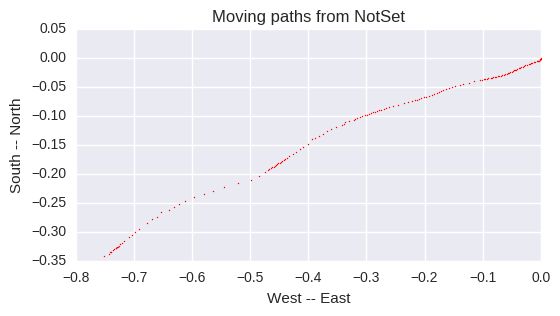

[ 0.30869862 -0.95092428 -0.02116878]
[-0.99063277  0.08916304 -0.09498086  0.0409306 ]


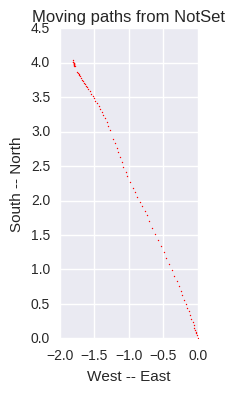

In [169]:
if __name__ == '__main__':
    only_dso = 1
    path_to_dso = '/data/hxu/OpenSfM/opensfm/car/dso.txt.0021'
    path_to_orb = '/data/hxu/OpenSfM/opensfm/car/orb.txt.0021'
    if only_dso == True:
        dso_content = parse_dso(path_to_dso)
        visLoc(dso_content)
        orb_content = parse_orb(path_to_orb)
        #print(orb_content.T)
        visLoc(orb_content.T)
        
    if 1 != True:
        path_to_camera = '/data/hxu/OpenSfM/data/47_dup/reconstruction.json'
        #path_to_camera = '/data/yang/data/opensfm/2edf359c-5bea-42e8-b9be-0e180a7939e5_gps/reconstruction.json'
        #path_to_camera = '/data/yang/data/opensfm/4c540278-3855-4d7c-9186-ea8dab80fbcd_gps/reconstruction.json'
        #path_to_camera = '/data/yang/data/opensfm/4754b660-8162-439e-a5c8-3b66c8479ebc/reconstruction.json
        #path_to_camera = '/data/hxu/OpenSfM/data/33bfbd1a-480d-49b6-803b-d2f1f8b56331/reconstruction.json'
        path_to_gps = '/data/nx-bdd-20160929/ride/5502d0bfb3f65da76a82fb159ce75e21/ride.json'  #for 47
        #path_to_gps = '/data/nx-bdd-20160929/ride/9883503a725270d64f0428f62e63e34a/ride.json'
        #path_to_gps = '/data/yang/data/opensfm/2edf359c-5bea-42e8-b9be-0e180a7939e5/ride.json'
        #path_to_gps = '/data/yang/data/opensfm/4c540278-3855-4d7c-9186-ea8dab80fbcd/ride.json'
        #path_to_gps = '/data/nx-bdd-20160929/ride/07072a93a9ef38216e283622619b77af/ride.json' #for 33
        #path_to_video = '121f354f-650c-407c-a26b-cccbb4f15e3f.mov'
        path_to_video = '47fa6807-46b4-4121-848b-beb291cc2d60.mov'
        #path_to_video = '2edf359c-5bea-42e8-b9be-0e180a7939e5.mov'
        #path_to_video = '33bfbd1a-480d-49b6-803b-d2f1f8b56331.mov'
        content = get_gps(path_to_gps, path_to_video)
        content['course']=fill_missing_speeds_and_courses(content['course'],1)
        out = get_interpolated_speed(path_to_gps, path_to_video, 30)
        x,y = gps_to_loc(out, 30)
        loc = np.array([x,y])
        Z = np.expand_dims(np.zeros_like(x),0)
        loc = np.concatenate((loc,Z),axis=0)
        
        
        
        R, T, Name = camera_motion(path_to_camera,loc)
        P = camera_pose(R,T)
        T_ = np.array(P).T
        
        
        
        #visLoc(np.array(T))
        #w = R.dot(np.array(T).T)
        #print(w.T)
        #visLoc(w.T)
        #print(path_to_camera)
        #pln = fit_plane(T)
        #R_proj = compute_R(pln,np.array([0,0,1]))
        #T_ = R_proj.dot(np.array(T).T)
        #T_ = T_.T
        s = compute_scale(P, Name, loc)
        sc = np.mean(s)
        loc_scale, P_scale = align(loc, P, sc)
        loc_scale_new = rotate_gps(loc_scale, P_scale, Name)
        
    
        visLoc(loc_scale_new)

        visLoc(P_scale)
        #visLoc(loc_scale_new)
        single_vis(loc_scale_new, P_scale)
        #single_vis(loc_scale_new[0:35], P_scale[0:35],label='Details at the starting point',s=3)
        angle, a1, a2, e = evaluation_rel(loc.T, P, image_list_file='/data/hxu/OpenSfM/data/47fa6807-46b4-4121-848b-beb291cc2d60/'+'image_list.txt')
        #print(angle)

91.8415693902
90.1959632747
6.33774337444
0.101073703571


'\nplt.plot(s)\nnp.mean(s)\n'

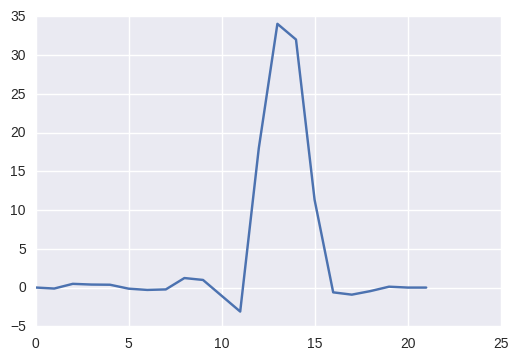

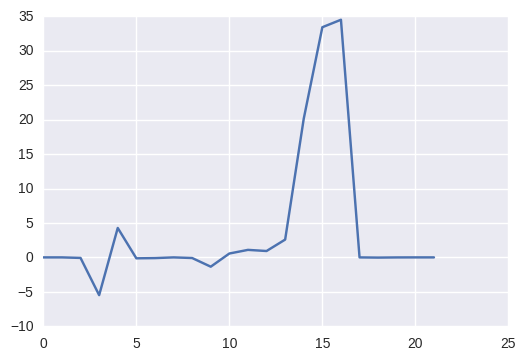

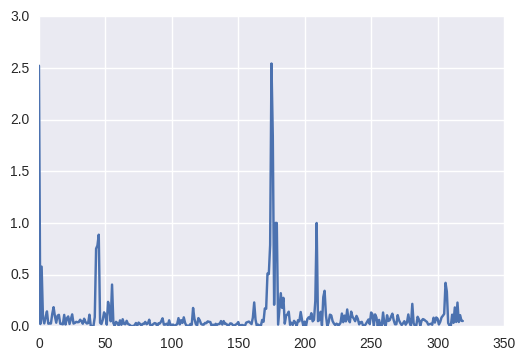

In [108]:
plt.plot(a1)
plt.figure()
plt.plot(a2)
print(np.sum(a1))
print(np.sum(a2))
print(np.mean(np.abs(angle)))
print(np.mean(e))
plt.figure()
plt.plot(e)

'''
plt.plot(s)
np.mean(s)
'''

In [132]:
orb_content

[array([ -1.99756996e-05,   6.70449481e-06,   3.96104224e-05], dtype=float32),
 array([ -1.08440865e-04,  -1.89187238e-03,   1.10744752e-01], dtype=float32),
 array([-0.00060196, -0.00264032,  0.15857969], dtype=float32),
 array([-0.00149146, -0.00339501,  0.22139007], dtype=float32),
 array([-0.00190075, -0.00361688,  0.26820937], dtype=float32),
 array([-0.00340365, -0.00455047,  0.33141977], dtype=float32),
 array([-0.00397348, -0.00463426,  0.37890071], dtype=float32),
 array([-0.00541364, -0.00507706,  0.42504379], dtype=float32),
 array([-0.00735814, -0.00584063,  0.50356311], dtype=float32),
 array([-0.00951042, -0.00664022,  0.58004576], dtype=float32),
 array([-0.01151894, -0.00745861,  0.65693915], dtype=float32),
 array([-0.01441429, -0.0082943 ,  0.73318338], dtype=float32),
 array([-0.01617489, -0.00900175,  0.77891338], dtype=float32),
 array([-0.01818245, -0.01000102,  0.8220346 ], dtype=float32),
 array([-0.02104024, -0.01068936,  0.89701462], dtype=float32),
 array([-0

In [133]:
dso_content

[array([ -1.99756996e-05,   6.70449481e-06,   3.96104224e-05], dtype=float32),
 array([ -1.08440865e-04,  -1.89187238e-03,   1.10744752e-01], dtype=float32),
 array([-0.00060196, -0.00264032,  0.15857969], dtype=float32),
 array([-0.00149146, -0.00339501,  0.22139007], dtype=float32),
 array([-0.00190075, -0.00361688,  0.26820937], dtype=float32),
 array([-0.00340365, -0.00455047,  0.33141977], dtype=float32),
 array([-0.00397348, -0.00463426,  0.37890071], dtype=float32),
 array([-0.00541364, -0.00507706,  0.42504379], dtype=float32),
 array([-0.00735814, -0.00584063,  0.50356311], dtype=float32),
 array([-0.00951042, -0.00664022,  0.58004576], dtype=float32),
 array([-0.01151894, -0.00745861,  0.65693915], dtype=float32),
 array([-0.01441429, -0.0082943 ,  0.73318338], dtype=float32),
 array([-0.01617489, -0.00900175,  0.77891338], dtype=float32),
 array([-0.01818245, -0.01000102,  0.8220346 ], dtype=float32),
 array([-0.02104024, -0.01068936,  0.89701462], dtype=float32),
 array([-0

mean value: 9 for 33...
mean value: 6.33 for 47...